In [4]:
from recast.CPT import CPT
import numpy as np
from pathlib import Path

# Risø campus

In [1]:
!pwd

/Volumes/Secondary_Drive/work/projects/campaign-planning-tool/CPT


In [36]:
layout = CPT()
layout.MESH_EXTENT = 5000 # in m
layout.MESH_RES = 100 # in m
layout.AVERAGE_RANGE = 4000 # in m 
layout.PULSE_LENGTH = 200 # in ns
layout.FFT_SIZE = 64 # no points
layout.ACCUMULATION_TIME = 1000 # in ms

# setting path to the folder 
# where to store the output data
layout.set_path('/Users/niva/Desktop/recast-test', 
                path_type = 'output')

# setting path to the landcover data 
layout.set_path('/Volumes/Secondary_Drive/work/projects/campaign-planning-tool/data/input/landcover/g100_clc12_V18_5.tif', 
                path_type = 'landcover')

layout.set_utm_zone('33T')
layout.MAX_ELEVATION_ANGLE = 45

points = np.array([
[576697.34, 4845753, 395 + 80],
[576968, 4845595, 439 + 80],
[577215, 4845425, 423 + 80],
[577439, 4845219, 430 + 80],
[577752, 4845005, 446 + 80],
[577979, 4844819, 478 + 80],
[578400, 4844449, 453 + 80],
[578658, 4844287, 450 + 80],
[578838, 4844034, 430 + 80],
[578974, 4843842, 417 + 80],
[579121, 4844186, 413 + 80],
[579246, 4843915, 410 + 80]
])
layout.add_measurement_instances(points = points, points_type = 'initial')
layout.generate_mesh()

Path /Users/niva/Desktop/recast-test set for storing CPT outputs
Path /Volumes/Secondary_Drive/work/projects/campaign-planning-tool/data/input/landcover/g100_clc12_V18_5.tif set for landcover data
Correct latitudinal zone!
Correct longitudinal zone!
UTM zone set
Measurement points 'initial' added to the measurements dictionary!
Measurements dictionary contains 1 different measurement type(s).


In [37]:
layout.generate_combined_layer(points_type = 'initial')

Generating combined layer for initial measurement points!
Correct latitudinal zone!
Correct longitudinal zone!
Station 1 of 1
Station 1 of 1
Station 1 of 1
Station 1 of 1
Station 1 of 1
Station 1 of 1
Station 1 of 1
Station 1 of 1
Station 1 of 1
Station 1 of 1
Station 1 of 1
Station 1 of 1


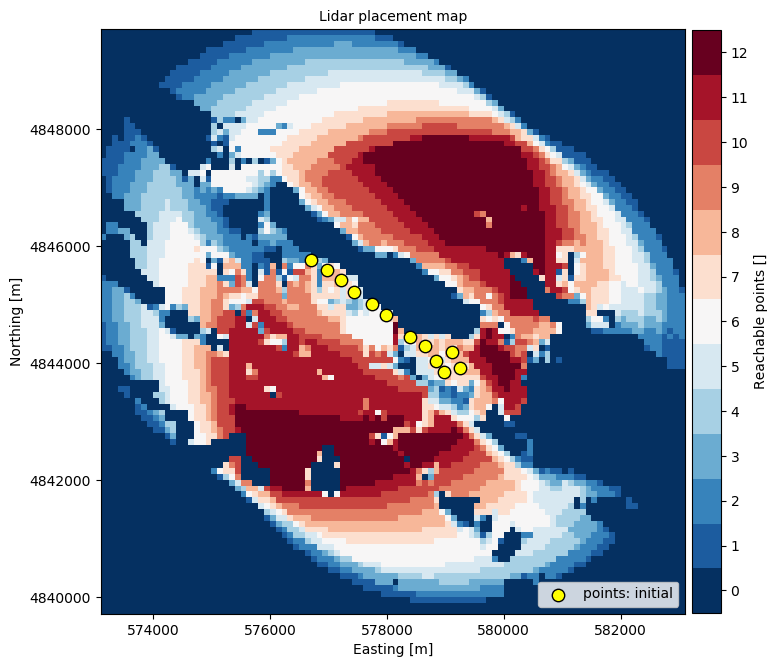

In [38]:
layout.plot_layer(layout.layer_selector('combined'), 
                  title = 'Lidar placement map' , 
                  legend_label = 'Reachable points []')

In [39]:
layout.add_lidar_instance(position = np.array([580800 - 1800,4845300 + 2500, 271]),
                          lidar_id = 'brise')

Lidar 'brise' added to the lidar dictionary, which now contains 1 lidar instance(s).


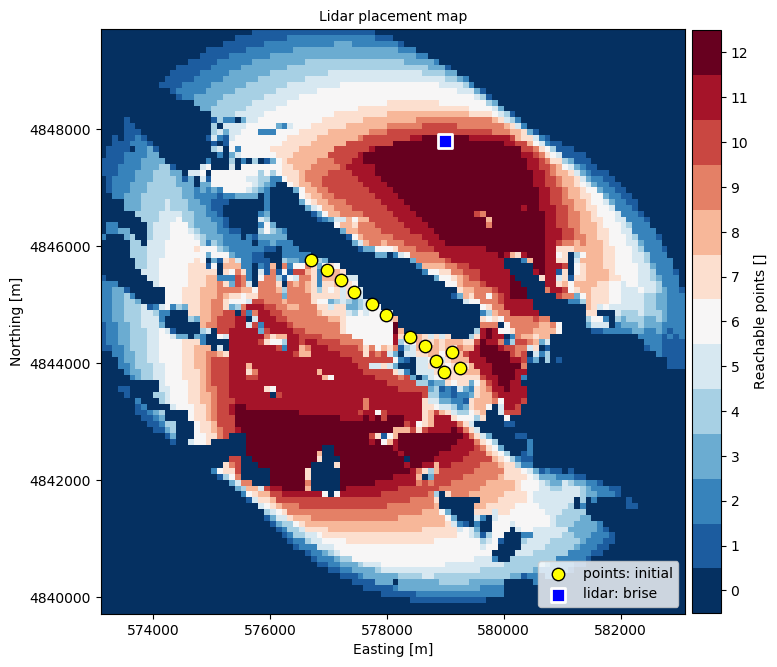

In [40]:
layout.plot_layer(layout.layer_selector('combined'), 
                  title = 'Lidar placement map' , 
                  legend_label = 'Reachable points []')

In [41]:
layout.generate_second_lidar_layer(lidar_id = 'brise')

Updating lidar instance 'brise' considering measurement type 'initial'.


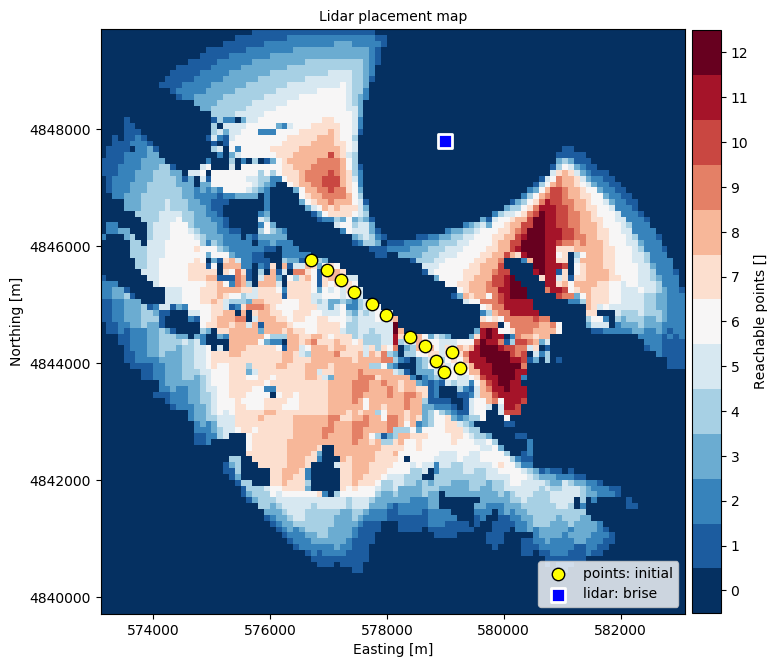

In [42]:
layout.plot_layer(layout.layer_selector('second_lidar_placement'), 
                  title = 'Lidar placement map' , 
                  legend_label = 'Reachable points []')

In [43]:
layout.add_lidar_instance(position = np.array([579400 + 1200,4847700 - 2000,100]), 
                          lidar_id = 'sirocco')

Lidar 'sirocco' added to the lidar dictionary, which now contains 2 lidar instance(s).


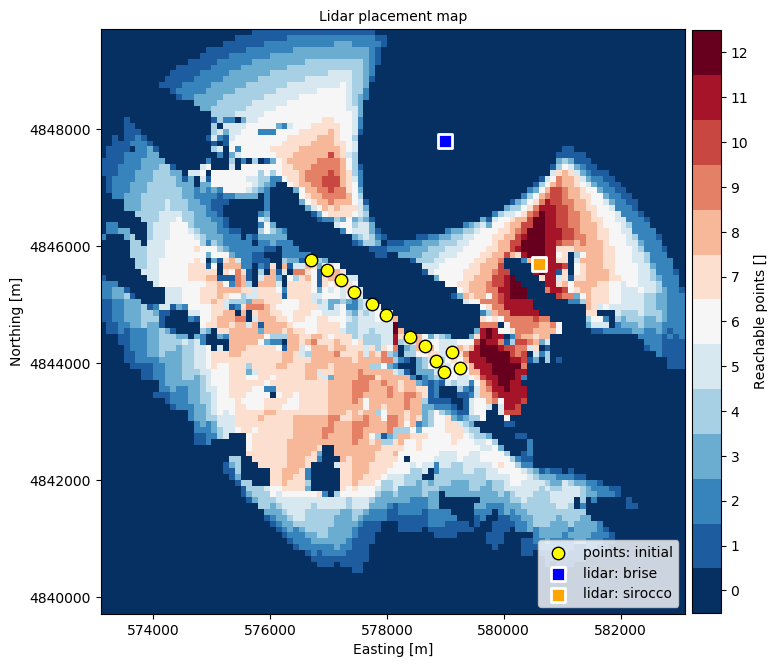

In [44]:
layout.plot_layer(layout.layer_selector('second_lidar_placement'), 
                  title = 'Lidar placement map' , 
                  legend_label = 'Reachable points []')

In [45]:
layout.optimize_trajectory(lidar_ids = ['brise', 'sirocco'], points_type = 'initial', sync = True)

Lidar instances:['brise', 'sirocco'] will be updated with the optimized trajectory
Updating lidar instance 'brise' considering measurement type 'initial'.
Updating lidar instance 'sirocco' considering measurement type 'initial'.
Synchronizing trajectories for lidar instances:['brise', 'sirocco']


In [49]:
layout.export_measurement_scenario(lidar_ids = ['brise', 'sirocco'])

In [16]:
layout.lidar_dictionary['brise']['trajectory']

,Point no.,Easting [m],Northing [m],Height asl [m]
0,1,317655.989,6174941.068,22.3067
1,2,317655.989,6174941.068,32.3067
2,3,317655.989,6174941.068,42.3067
3,4,317655.989,6174941.068,52.3067
4,5,317655.989,6174941.068,62.3067
5,6,317655.989,6174941.068,72.3067
6,7,317655.989,6174941.068,82.3067
7,8,317655.989,6174941.068,92.3067
8,9,317655.989,6174941.068,102.3067
9,10,317655.989,6174941.068,112.3067


In [47]:
import simplekml
def export_kml(self, **kwargs):

    # first check if lidar_ids exist in kwargs
    # and in lidar_dictionary
    if('lidar_ids' in kwargs and 
        set(kwargs['lidar_ids']).issubset(self.lidar_dictionary)
        ):

        kml = simplekml.Kml()

        lidar_pos_utm = [self.lidar_dictionary[lidar]['position'] for lidar in kwargs['lidar_ids']]
        lidar_pos_utm = np.asarray(lidar_pos_utm)
        lidar_pos_geo = self.utm2geo(lidar_pos_utm, self.long_zone, self.hemisphere)

        for i,lidar in enumerate(kwargs['lidar_ids']):
            kml.newpoint(name = lidar, 
                         coords=[(lidar_pos_geo[i][1], 
                                  lidar_pos_geo[i][0], 
                                  lidar_pos_geo[i][2])],
                         altitudemode = simplekml.AltitudeMode.relativetoground)

        trajectories = [self.lidar_dictionary[lidar]['trajectory'].values 
                        for lidar in kwargs['lidar_ids']]
        trajectories = np.asarray(trajectories)
        trajectories_lengths = [len(single) for single in trajectories]

        if trajectories_lengths[1:] == trajectories_lengths[:-1]:
            if np.all(np.all(trajectories == trajectories[0,:], axis = 0)):
                flag = True

                trajectory_geo = self.utm2geo(trajectories[0][:,1:], self.long_zone, self.hemisphere)
                
                trajectory_geo[:, 0], trajectory_geo[:, 1] = trajectory_geo[:, 1], trajectory_geo[:, 0].copy()
                
                trajectory_geo_tuple = [tuple(l) for l in trajectory_geo]
                
                ls = kml.newlinestring(name="Trajectory")
                ls.coords = trajectory_geo_tuple
                ls.altitudemode = simplekml.AltitudeMode.absolute
                ls.style.linestyle.width = 2
                ls.style.linestyle.color = simplekml.Color.white
                
                for i, pt_coords in enumerate(trajectory_geo_tuple):
                    pt = kml.newpoint(name = 'pt_' + str(i + 1))
                    pt.coords = [pt_coords]
                    pt.style.iconstyle.icon.href = 'http://maps.google.com/mapfiles/kml/shapes/placemark_circle.png'
                    pt.altitudemode = simplekml.AltitudeMode.absolute
                    
                    
                for layer in kwargs['layers']:                    
                    self.export_layer(layer_type = layer)
                    file_name_str = layer + '.tif'
#                    file_path = self.OUTPUT_DATA_PATH.joinpath(file_name_str)
                    
                    map_center = np.mean(self.mesh_corners_geo, axis = 0)
                    ground = kml.newgroundoverlay(name = layer)

                    ground.icon.href = file_name_str
                    ground.latlonbox.north = self.mesh_corners_geo[1,0]
                    ground.latlonbox.south = self.mesh_corners_geo[0,0]
                    ground.latlonbox.east = self.mesh_corners_geo[1,1]
                    ground.latlonbox.west = self.mesh_corners_geo[0,1]
                    ground.color="7Dffffff"

                    ground.lookat.latitude = map_center[0]
                    ground.lookat.longitude = map_center[1]
                    ground.lookat.range = 200
                    ground.lookat.heading = 0
                    ground.lookat.tilt = 0                    
                    
                    

                
                
                
                file_name_str = "campaign_design.kml"
                file_path = self.OUTPUT_DATA_PATH.joinpath(file_name_str)
                kml.save(file_path.absolute().as_posix())
            else:
                flag = False
                print('Trajectories are not the same')
        else:
            flag = False
            print('Trajectories are not the same') 

In [48]:
export_kml(layout, lidar_ids = ['brise', 'sirocco'], layers = ['combined', 'second_lidar_placement'])

In [34]:
layout.LAYER_TYPE


array(['orography', 'landcover', 'canopy_height', 'topography',
       'restriction_zones', 'elevation_angle_contrained',
       'range_contrained', 'los_blockage', 'combined',
       'intersecting_angle_contrained', 'second_lidar_placement',
       'aerial_image', 'misc'], dtype='<U29')

In [ ]:
    map_center = np.mean(corners_lat_long, axis = 0)
    kml = simplekml.Kml()


    ground = kml.newgroundoverlay(name = layer_name)

    ground.icon.href = file_name
    ground.latlonbox.north = np.max(corners_lat_long[0,0])
    ground.latlonbox.south = np.min(corners_lat_long[2,0])
    ground.latlonbox.east = np.min(corners_lat_long[0,1])
    ground.latlonbox.west = np.max(corners_lat_long[2,1])
    ground.color="7Dffffff"

    ground.lookat.latitude = map_center[0]
    ground.lookat.longitude = map_center[1]
    ground.lookat.range = view_height
    ground.lookat.heading = 0
    ground.lookat.tilt = 0